<a href="https://colab.research.google.com/github/arunmishrarut/Credit-card-fraud/blob/main/Oversampling_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction
This notebook presents a novel approach to handle imbalanced datasets using a model-driven oversampling strategy. For benchmarking it, four models are compared:

* **Custom Oversampling**: A unique, model-aware oversampling technique proposed here by me.

* **Baseline**: No oversampling, using the original data.

* **SMOTE**: Synthetic Minority Over-sampling Technique.

* **ADASYN**: Adaptive Synthetic Sampling.

* **TabNet**: Transformer based architecture provided by google which uses sequential attention mechanism to choose which features to reason from at each decision step.  

Each model is evaluated using a comprehensive suite of metrics and visualizations, guided by best practices from statistical learning theory.

**Note**: <br>
Runtime ~ 5 mins   (on GPU); ~ 15 hours (on CPU)

# 2. Data Preparation





# Dataset
* The dataset I used is probably the most famous dataset for credit card fraud availble on internet.

* It can be sourced from [6] Many people have used it for their projects.

*  However, I did not find any project which was even remotely similar to my approach.

* Although, I have used those projects approach for benchmarking purposes againts my approach.

### 1. Data Splitting




* The dataset is split into **80% training** and **20% test** sets, **stratified by the fraud label** to preserve class distribution.

**Labeling Convention:**

Class 0 = Legitimate;  Positive Class

Class 1 = Fraudulent ; Negative Class



In [ ]:
#!pip -q install pytorch-tabnet

In [ ]:
# Importing needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc, roc_auc_score,
    average_precision_score, matthews_corrcoef, log_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
import xgboost as xgb
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('data1.csv')
train, test = train_test_split(
    data, test_size=0.2, stratify=data['Class'], random_state=43)

In [ ]:
print(data.shape())
print(train.shape())
print(test.shape()

**Note**: The test set is held out and is never used during oversampling to avoid data leakage.

###2. Stratified Subdivision of Training Data


* The training set is divided into 6 equal, non-overlapping subsets using StratifiedKFold.

* Each subset retains the original class ratio and ensures exclusive membership—no data point appears in more than one subset.


In [ ]:
# Dividing the train dataset into 6 subdatasets as per approach
n_subsets = 6
skf = StratifiedKFold(n_splits=n_subsets, shuffle=True, random_state=42)
subsets = []
for i, (_, idx) in enumerate(skf.split(train, train['Class'])):
    subset = train.iloc[idx].copy()
    subset['subset'] = f'sub{i+1}'
    subsets.append(subset)


# 3. Easy vs. Hard Cases
* **Easy frauds**: True frauds predicted with high confidence (above threshold **T**) will be excluded from further processing in subsiquent stages.

* **Easy legits**: True legitimate transactions predicted with low fraud probability (below threshold **B**) will also **excluded** from further processing in subsiquent stages.

The remaining, **hard-to-classify cases** are retained:

* **False Negatives (FN)**: Missed frauds

* **False Positives (FP)**: Incorrectly flagged legits


* **Uncertain predictions**: Correctly predicted but low-confidence cases

This idea is inspired by [1] and [2], which highlights the value of **not overwhelming the model** with redundant, confidently learned samples.

# 4. Nested Cross-Validation-style data subsets' usage to identify hard frauds and hard legitimate transactions:

For each of the six subsets, a nested cross-validation-like approach was used:


*   One subset is used as a validation subset.

*   Of the remaining five, one was held-out, and the other four were combined for training.**#The difference from cross-validation**.

* An XGBoost classifier was trained on it and validated on sixth evaluation subset.

* FNs, FPs and Uncertain predictions were identified and stored in a list as a df for particular instance.


*   Then next subset was held out; and model was trained (from scratch) on the next 4 subsets and validated on the sixth.

* Again,  FNs, FPs and Uncertain predictions were identified and stored in a list as a df for particular instance.



*  This process was repeated till all the subsets were held out one-by-one and each subset has not been used as a validation subset. This approach is unlike five fold-cross-validation, in which 5 subsets are used (instead of 4) for training and the remaining subset is used for validation.

That is total 5*6 = 30 cases of training ;and identification of FPs,FNs and Uncertain predictions

# **Benefits of this approach**
The impact of a particular data point on the feature space during model training depends heavily on the presence and distribution of surrounding points—not in terms of correlation, but in terms of spatial interaction. **This approach aims to leverage that synergistic effect to detect hard false negatives (missed frauds) that could have been identified if the excluded sample block had been part of the training set**.

**The goal here isn’t to chase bias or perfect model**. Instead, It will be better if this model operate below typical conditions—without tuning or aggressive performance enhancements—**so that broader, looser decision boundaries can naturally emerge. These boundaries then become fertile zones for oversampling**, making the resampling process more **robust and less dependent** on "by-chance" train-test splits or dataset.

This nuanced strategy is intended to reduce the method’s reliance **on training set characteristics**—such as the number of fraud cases or the presence of hard-to-detect frauds.

Additionally, one of the key **insight from my early research was that misclassification of legitimate transactions significantly affected fraud detection** performance. **That’s why** I chose to **oversample legitimate cases as well**. It reinforces the idea that a data point’s influence during training depends on its surrounding context, which must be accounted for when building more generalizable fraud detection models.



# 5. Adaptive Oversampling of False positive and False Negative Cases

**NOTE**: Throughout the notebook, I have assigned positive class or class 0 to legitimate transactions and Negative class or class 1 to Fraudulent transaction.



*   False Negatives (FNs): Missed frauds are oversampled, with the number of duplicates determined by the below step-up funtion:

FN multiplier = $\left\lceil \dfrac{\text{fold recall} \times \lambda_1 \times \text{frequency}^2}{\max( \text{predicted probability}, 0.01)} \right\rceil$

<br>

*   False Positives (FPs): Incorrectly flagged legits are oversampled with the number of duplicates determined by the below step-up funtion:

FP multiplier = $\left\lceil \dfrac{\text{fold precision} \times \lambda_2 \times \text{frequency}^2}{\max(1 - \text{predicted probability}, 0.01)} \right\rceil$
<br>

Here, $\lambda_1$ and $\lambda_2$ are tunable parameters, and **frequency** is number of times an instance is misclassified across folds. This ensures the hardest cases—where the model is least confident and most often wrong—are emphasized during oversampling.

### **First Derivative of the FN Multiplier** :

Since all other terms (λ₁, frequency, predicted probability) are constants with respect to FN, the derivative of the FN multiplier :
<br>

$
\frac{d}{dFN}(\text{FN multiplier}) = \text{constant} \times \frac{d}{dFN}(\text{recall}) = - \text{constant} \times \frac{TP}{(TP + FN)^2}
$

Therefore,
* **The FN multiplier decreases as the number of FN increases**.

* The decrease is steeper when FN is small and gradually flattens as FN increases, which helps **prevent overfitting to false negatives—especially if they occur in large numbers** in the dataset.

**The FP multiplier exhibits similar behavior**.


###Hyperparameters
$T$ : Top-limit for easy fraud probability (e.g. if T = 0.6, all correctly identified frauds with fraud predicted probability ≥ 0.6 are considered easy frauds and are excluded from each iteration. Legitimate cases remain unaffected.)

Similarly,

$B$: Bottom-limit for fraud probability for easy legit.(e.g. if B = 0.4, all correctly identified legitimate transactions with fraud predicted probability ≤ 0.4 are considered easy legitimates and are excluded from each iteration. Fraud cases remain unaffected.)

$\lambda_1$ : Strength parameter for oversampling FNs

$\lambda_2$ = Strength parameter for oversampling FPs

$fnlt$ : fasle-negative-lower-limit.If fnlt is 0.7, all instances with fraud probability below 0.7 are considered tough-to-identify frauds

$fput$ : Flase-positive-lower-limit.If fput is 0.35, all legitimate cases with predicted fraud probability above 0.35 are considered hard-to-identify legits.

$target fraud ratio$ : Desired fraud to legitimate ratio after oversampling. It will be tried to achieve with in fixed number of iterations under adjust_lambda_function. It will help me during further work on this project.




In [ ]:
# Main oversampling code block executing the strategy discussed
T = 0.55
B = 0.45
lamda_1 = 5
lamda_2 = 0
fnlt= 0.55
fput= 0.45
target_fraud_ratio = 0.5

# Storage
all_fn_rows, all_fn_probs, all_fn_recalls = [], [], []
all_fp_rows, all_fp_probs, all_fp_precisions = [], [], []
all_val_sub = []

for eval_idx in range(n_subsets):  # Outer: Evaluation block
    train_val_indices = [i for i in range(n_subsets) if i != eval_idx]
    for val_idx in train_val_indices:  # Inner: Leave-one-out from training blocks
        train_indices = [i for i in train_val_indices if i != val_idx]
        train_subs = pd.concat([subsets[i] for i in train_indices], ignore_index=True)
        val_sub = subsets[eval_idx].copy()  # Evaluation always on this fixed block
        X_train_sub = train_subs.drop(['Class', 'subset'], axis=1)
        y_train_sub = train_subs['Class']
        X_val = val_sub.drop(['Class', 'subset'], axis=1)
        y_val = val_sub['Class']

        model = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
        model.fit(X_train_sub, y_train_sub)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]

        # Calculate recall and precision for this fold (on remaining val_sub)
        fold_recall = recall_score(y_val, y_pred, zero_division=0)
        fold_precision = precision_score(y_val, y_pred, zero_division=0)

        # Remove easy frauds
        y_pred = pd.Series(y_pred, index=val_sub.index)
        y_proba = pd.Series(y_proba, index=val_sub.index)
        easy_frauds_idx = val_sub[(y_proba > T) & (y_val == 1)].index
        val_sub = val_sub.drop(easy_frauds_idx)
        y_val = y_val.drop(easy_frauds_idx)
        y_pred = y_pred.drop(easy_frauds_idx)
        y_proba = y_proba.drop(easy_frauds_idx)

        # Remove easy legits
        easy_legits_idx = val_sub[(y_proba < B) & (y_val == 0)].index
        val_sub = val_sub.drop(easy_legits_idx)
        y_val = y_val.drop(easy_legits_idx)
        y_pred = y_pred.drop(easy_legits_idx)
        y_proba = y_proba.drop(easy_legits_idx)

        # Collect remaining (tough) false negatives and false positives
        false_negatives_idx = val_sub[(y_val == 1) & (y_proba < fnlt)].index
        fn_rows = val_sub.loc[false_negatives_idx].copy()
        fn_probs = y_proba.loc[false_negatives_idx]
        fn_rows['fold_recall'] = fold_recall  # Store per-fold recall with each row, these will have prob < 0.5 because they are FN that is fraud but detected legit
        all_fn_rows.append(fn_rows)
        all_fn_probs.append(fn_probs)
        all_fn_recalls.append(pd.Series([fold_recall] * len(fn_rows), index=fn_rows.index))
        false_positives_idx = val_sub[(y_val == 0) & (y_proba > fput)].index
        fp_rows = val_sub.loc[false_positives_idx].copy()
        fp_probs = y_proba.loc[false_positives_idx]
        fp_rows['fold_precision'] = fold_precision  # Store per-fold precision with each row these will have prob > 0.5 because they are FN that is fraud but detected legit
        all_fp_rows.append(fp_rows)
        all_fp_probs.append(fp_probs)
        all_fp_precisions.append(pd.Series([fold_precision] * len(fp_rows), index=fp_rows.index))

        # all remaining less confidently identified cases
        all_val_sub.append(val_sub)

# Combine all tough cases and their associated probabilities and metrics
all_fn_rows = pd.concat(all_fn_rows, ignore_index=True)
all_fn_probs = pd.concat(all_fn_probs, ignore_index=True)
all_fn_recalls = pd.concat(all_fn_recalls, ignore_index=True)
all_fp_rows = pd.concat(all_fp_rows, ignore_index=True)
all_fp_probs = pd.concat(all_fp_probs, ignore_index=True)
all_fp_precisions = pd.concat(all_fp_precisions, ignore_index=True)
all_val_sub = pd.concat(all_val_sub, ignore_index=True)

all_val_sub = all_val_sub.sample(frac=1.0/25, random_state=42) #because val_sub effect is multipled to 25 times becasue of nested loops

# Count FN row frequency
fn_tuples = [tuple(row[:-1]) for row in all_fn_rows.to_numpy()]  # excluding 'fold_recall'
fn_counts = Counter(fn_tuples)
fn_repeat_multiplier = np.array([fn_counts[tuple(row[:-1])] for row in all_fn_rows.to_numpy()]) ** 2

# Count FN row frequency
fp_tuples = [tuple(row[:-1]) for row in all_fp_rows.to_numpy()]  # excluding 'fold_recall'
fp_counts = Counter(fp_tuples)
fp_repeat_multiplier = np.array([fp_counts[tuple(row[:-1])] for row in all_fp_rows.to_numpy()]) ** 2

# Now, apply oversampling with initial lambda values, using per-instance recall or precision
fn_repeat = np.ceil(all_fn_recalls * lamda_1*fn_repeat_multiplier / np.maximum(all_fn_probs, 0.01)).astype(int)
fn_oversampled = pd.DataFrame(
    np.repeat(all_fn_rows.values, fn_repeat, axis=0),
    columns=all_fn_rows.columns)

fp_repeat = np.ceil(all_fp_precisions * lamda_2*fp_repeat_multiplier / np.maximum((1-all_fp_probs), 0.01)).astype(int)
fp_oversampled = pd.DataFrame(
    np.repeat(all_fp_rows.values, fp_repeat, axis=0),
    columns=all_fp_rows.columns)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:13:56] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


#6. Class Ratio Adjustment using "adjust_lambdas" function as discussed above

This custom function adjust_lambdas() adjusts λ₁ and λ₂ iteratively to reach a **target fraud ratio**, while ensuring the **oversampled dataset remains smaller than the original training set.**

**Key Objectives:**
* Achieve desired fraud ratio.

* Avoid exploding dataset size.
* It only runs for fixed number of iterations, no matter ratio is achieved or not. It is done to avoid excess oversampling. It will also help during further work on this project.









In [ ]:
# Lambda function
def adjust_lambdas(train, fn_oversampled, fp_oversampled,all_fn_rows, all_fn_probs, all_fn_recalls,
                   all_fp_rows, all_fp_probs, all_fp_precisions,all_val_sub,
                   target_fraud_ratio):

    lam1, lam2 = lamda_1, lamda_2

    for _ in range(1):  # max 100 iterations
        # Recalculate oversampled sets with updated lambdas and per-instance recall/precision
        fn_repeat = np.ceil(all_fn_recalls * lam1 / np.maximum(all_fn_probs, 0.01)).astype(int)
        fn_oversampled = pd.DataFrame(
            np.repeat(all_fn_rows.values, fn_repeat, axis=0),
            columns=all_fn_rows.columns)

        fp_repeat = np.ceil(all_fp_precisions * lam2 /np.maximum((1-all_fp_probs), 0.01)).astype(int)
        fp_oversampled = pd.DataFrame(
            np.repeat(all_fp_rows.values, fp_repeat, axis=0),
            columns=all_fp_rows.columns)

        # Combine oversampled data
        oversampled_data = pd.concat([fn_oversampled, fp_oversampled,all_val_sub], ignore_index=True)

        # Combine with original train
        combined_dataset = pd.concat([train, oversampled_data], ignore_index=True)

        # Calculate fraud ratio
        fraud_ratio = combined_dataset['Class'].mean()  # mean of binary Class = ratio of 1s

        # Check if it's close enough to target
        if abs(fraud_ratio - target_fraud_ratio) < 0.01:
            break

        # Adjust lambdas based on fraud ratio
        if fraud_ratio < target_fraud_ratio:
            lam1 += 1
        else:
            lam2 += 1

        lam1 = max(lam1, lamda_1)
        lam2 = max(lam2, lamda_2)
        if _ % 10 == 0:
            print(_)

        if len(oversampled_data) > len (train):
          break

    return lam1, lam2, oversampled_data, fraud_ratio , combined_dataset, fn_oversampled, fp_oversampled

# 7. Key Outputs

In [ ]:
# Key outputs and relevent results.
lamda_1, lamda_2, oversampled_final, fraud_ratio, combined_dataset, fn_oversampled, fp_oversampled = adjust_lambdas(train, fn_oversampled, fp_oversampled,all_fn_rows,
                                                     all_fn_probs, all_fn_recalls,
                                                     all_fp_rows, all_fp_probs, all_fp_precisions,all_val_sub,
                                                     target_fraud_ratio)

print("\n==================================")
print(f"\nFinal lamda_1: {lamda_1}, lamda_2: {lamda_2}")
print(f"Total samples remaing in train set after removing easy fraud and easy legits: {len(all_val_sub)} out of {len(train)}")
print(f"Fraud ratio in oversampled set: {oversampled_final['Class'].mean():.3f}")
print(f"Fraud ratio in set obtained after adding oversampled with train set: {combined_dataset['Class'].mean():.3f}")
print(f"Tough fraud samples added by oversampling (False Negatives, FNs): {len(fn_oversampled)}")
print(f"Toughest fraud samples added by oversampling (False Positives, FPs): {len(fn_counts)}")
print(f"Tough legitimate samples added by oversampling (False Positives, FPs): {len(fp_oversampled)}")
print(f"Toughest legitimate samples added by oversampling (False Negatives, FNs): {len(fp_counts)}")
print("\n==================================")
print(f"Samples added by oversampling: {len(oversampled_final)}")
print(f"train: {train['Class'].value_counts()}")
print(f"oversampled: {oversampled_final['Class'].value_counts(ascending=True)}")
print(f"combined dataset : {combined_dataset['Class'].value_counts()}")




0


Final lamda_1: 6, lamda_2: 0
Total samples remaing in train set after removing easy fraud and easy legits: 22 out of 227845
Fraud ratio in oversampled set: 1.000
Fraud ratio in set obtained after adding oversampled with train set: 0.377
Tough fraud samples added by oversampling (False Negatives, FNs): 137055
Toughest fraud samples added by oversampling (False Positives, FPs): 100
Tough legitimate samples added by oversampling (False Positives, FPs): 0
Toughest legitimate samples added by oversampling (False Negatives, FNs): 31

Samples added by oversampling: 137077
train: Class
0    227451
1       394
Name: count, dtype: int64
oversampled: Class
0         5
1    137072
Name: count, dtype: int64
combined dataset : Class
0    227456
1    137466
Name: count, dtype: int64


#8. Removing unnnecessary columns.
 Clean and prepare the final dataset by removing unnecessary columns and ensuring all values are numeric to prevent errors during model training

In [ ]:
# Combine dataframes and convert to numeric, coercing errors
df_new = pd.concat([combined_dataset], ignore_index=True).apply(pd.to_numeric, errors='coerce')

# Drop specific helper columns if they exist
cols_to_drop = ['fold_recall', 'fold_precision', 'subset']
df_new = df_new.drop(columns=[col for col in cols_to_drop if col in df_new.columns])

# Optionally drop rows with NaNs introduced by to_numeric
df_new.dropna(inplace=True)

#9. Train two XGBoost models for comparison:

**Model1**: Trained on the original dataset without oversampling, serving as a baseline for performance comparison.

**Model2**: Trained on the oversampled dataset to evaluate the impact of oversampling techniques on model performance.

In [ ]:
# Model1 and Model2 training block
threshold = 0.1 # threshold for all , oversmpled, non over sampled and SMOTE and ADASYN

# Model 1 training for comparison
train_model1 = train.copy()

# Separate features (X) and target (y) for Model 1 training
X_train_model1 = train_model1.drop('Class', axis=1)
y_train_model1 = train_model1['Class']

# Separate features (X) and target (y) for Model 2 training
train_model2 = df_new.copy()
X_train_model2 = train_model2.drop('Class', axis=1)
y_train_model2 = train_model2['Class']

# Separate features (X) and target (y) for test (final evaluation)
X_test = test.drop('Class', axis=1)
y_test = test['Class']




# Ensure data types are suitable for XGBoost and other models
X_train_model1 = X_train_model1.astype(float)
y_train_model1 = y_train_model1.astype(float)
X_train_model2 = X_train_model2.astype(float)
y_train_model2 = y_train_model2.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

# Initialize and train the first XGBoost model (Model 1) on train_model1 without over sampling
model1 = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
model1.fit(X_train_model1, y_train_model1)

# Predict probabilities and apply custom threshold
y_pred1 = model1.predict(X_test)
y_prob_preds1 = model1.predict_proba(X_test)[:, 1]
y_score1 = (y_prob_preds1 > threshold).astype(int)

# Initialize and train the second model (Meta-model) on the meta-model training data with over sampling
model2= xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
model2.fit(X_train_model2, y_train_model2)

# Predict probabilities and apply custom threshold
y_pred2 = model2.predict(X_test)
y_prob_preds2 = model2.predict_proba(X_test)[:, 1]
y_score2 = (y_prob_preds2 > threshold).astype(int)


# 10. Comparison of Model 1 and Model 2 performance

This section evaluates and compares the baseline model (Model1) and the oversampled model (Model2) using several metrics:

* **Confusion Matrix**

* **Accuracy**

* **Classification Report**

* **AUC (Area Under the ROC Curve)**

* **ROC Curve**

* **Precision-Recall Curve**

* **Visualizations for ROC and Precision-Recall curves are plotted side by side for clearer comparison.**

Test Accuracy1: 0.9996
Classification Report without oversampling:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.90      0.85      0.87        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
 [[56855     9]
 [   15    83]]

AUC:0.9234


Test Accuracy2: 0.9996
Classification Report with 137077 oversampling:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.89      0.89      0.89        98

    accuracy                           1.00     56962
   macro avg       0.94      0.94      0.94     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
 [[56853    11]
 [   11    87]]

AUC:0.9860


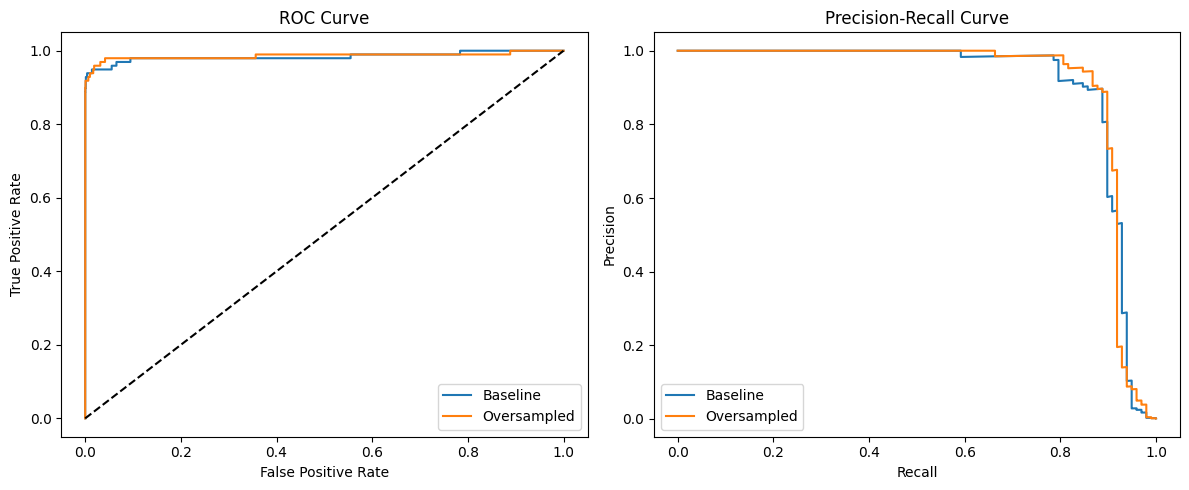

In [ ]:
# Classification reports ;and precision-recall and ROC curve

# Evaluate the results for baseline model without oversmapling
print(f"Test Accuracy1: {accuracy_score(y_test, y_score1):.4f}")
print("Classification Report without oversampling:\n", classification_report(y_test, y_score1))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_score1))
auc = roc_auc_score(y_test, y_score1) # Use X_meta_test here
print()
print(f"AUC:{auc:.4f}")
print("\n")

# Evaluate the results for oversampled model(proposed method)
print(f"Test Accuracy2: {accuracy_score(y_test, y_score2):.4f}")
print(f"Classification Report with {len(oversampled_final)} oversampling:\n", classification_report(y_test, y_score2))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_score2))
print()

# Calculate the AUC score for the ensemble model (meta-model) on test data.
auc = roc_auc_score(y_test, y_prob_preds2) # Use X_meta_test here
print(f"AUC:{auc:.4f}")
plt.figure(figsize=(12, 5))


# ROC Curve
plt.subplot(1, 2, 1)
fpr1, tpr1, _ = roc_curve(y_test, model1.predict_proba(X_test)[:, 1])
fpr2, tpr2, _ = roc_curve(y_test, model2.predict_proba(X_test)[:, 1])
plt.plot(fpr1, tpr1, label='Baseline')
plt.plot(fpr2, tpr2, label='Oversampled')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# PR Curve
plt.subplot(1, 2, 2)
prec1, rec1, _ = precision_recall_curve(y_test, model1.predict_proba(X_test)[:, 1])
prec2, rec2, _ = precision_recall_curve(y_test, model2.predict_proba(X_test)[:, 1])
plt.plot(rec1, prec1, label='Baseline')
plt.plot(rec2, prec2, label='Oversampled')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.tight_layout()
plt.show()

# Data Leakage Test model2 (my approach)
To ensure the integrity of the evaluation and confirm that there was no data leakage from the test set into Model 2 (trained on the oversampled data), a simple yet effective test was performed:

* The true test labels (y_test) were randomly shuffled, breaking any meaningful correspondence between features and labels.

* The Area Under the ROC Curve (AUC) was then calculated using the model’s predicted probabilities (y_prob_preds2) against these shuffled labels.

Since the labels are randomized, a well-behaved model should perform no better than chance on this shuffled data.


In [ ]:
# Data leakage test
shuffled_auc = roc_auc_score(shuffle(y_test, random_state=42), y_prob_preds2)
print("AUC with shuffled test labels (should be ~0.5):", shuffled_auc)



AUC with shuffled test labels (should be ~0.5): 0.5015763533184798


# 11. Training advanced oversampling models: SMOTE and ADASYN

This section implements and trains two additional oversampling techniques for comparison against the proposed oversampled model:

SMOTE (Synthetic Minority Over-sampling Technique): Generates synthetic samples by interpolating between existing minority class instances.

ADASYN (Adaptive Synthetic Sampling): Similar to SMOTE but adaptively focuses on harder-to-learn examples.

Each method is applied to the training set only, followed by training an XGBoost classifier.
Performance is evaluated on the same test set using predicted class probabilities with a custom threshold.

In [ ]:
# SMOTE and ADASYN for comparison
train = train.copy()
X_train_smote = train.drop('Class', axis=1)
y_train_smote = train['Class']

X_test = test.drop('Class', axis=1)
y_test = test['Class']

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_res_smote, y_train_res_smote = smote.fit_resample(X_train_smote, y_train_smote)

# Show class distribution before and after SMOTE
print("Before SMOTE:", Counter(y_train_smote))
print("After SMOTE:", Counter(y_train_res_smote))

# Calculate how many synthetic samples were added
added_samples = len(y_train_res_smote) - len(y_train_smote)
print(f"\nSMOTE added {added_samples} synthetic samples.")

# Train XGBoost classifier with GPU
model_smote = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
model_smote.fit(X_train_res_smote, y_train_res_smote)

# Predict on test set
y_pred_smote = model_smote.predict(X_test)
y_pred_prob_smote = model_smote.predict_proba(X_test)[:, 1]  # Needed for curves
y_pred_prob_smote = (y_pred_prob_smote > threshold).astype(int)

#Apply ADASYN only on train dataset
X_train_ada = train.drop('Class', axis=1)
y_train_ada = train['Class']

adasyn = ADASYN(random_state=42)
X_train_res_ada, y_train_res_ada = adasyn.fit_resample(X_train_ada, y_train_ada)

# Show class distribution before and after ADASYN
print("Before ADASYN:", Counter(y_train_ada))
print("After ADASYN:", Counter(y_train_res_ada))

# Calculate how many synthetic samples were added
added_samples = len(y_train_res_ada) - len(y_train_ada)
print(f"\nADASYN added {added_samples} synthetic samples.")

# Train XGBoost classifier with GPU
model_ada = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
model_ada.fit(X_train_res_ada, y_train_res_ada)

# Predict on test set
y_pred_ada = model_ada.predict(X_test)
y_pred_prob_ada = model_ada.predict_proba(X_test)[:, 1]
y_pred_prob_ada = (y_pred_prob_ada > threshold).astype(int)


Before SMOTE: Counter({0: 227451, 1: 394})
After SMOTE: Counter({0: 227451, 1: 227451})

SMOTE added 227057 synthetic samples.
Before ADASYN: Counter({0: 227451, 1: 394})
After ADASYN: Counter({1: 227513, 0: 227451})

ADASYN added 227119 synthetic samples.


In [ ]:
#Tabnet from google optimsed transformer struture for tabular data and imbalanced dataset

# Convert to NumPy arrays
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

# Encode labels to 0/1 if needed
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_np)
y_test_enc = le.transform(y_test_np)

# Initialize TabNet
clf = TabNetClassifier(
    n_d=16, n_a=16,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1,
    seed=42
)

# Fit TabNet
clf.fit(
    X_train=X_train_np, y_train=y_train_enc,
    eval_set=[(X_test_np, y_test_enc)],
    eval_name=['test'],
    eval_metric=['accuracy'],
    max_epochs=30,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)

# Predict and evaluate
y_pred = clf.predict(X_test_np)

print("\n[TabNet] Classification Report on Test Set:")
print(classification_report(y_test_enc, y_pred, target_names=["Non-Fraud", "Fraud"]))

print("[TabNet] Confusion Matrix on Test Set:")
print(confusion_matrix(y_test_enc, y_pred, labels=[0, 1]))

print("Accuracy:", accuracy_score(y_test, clf.predict_proba(X_test_np)[:, 1])
print("AUC:", roc_auc_score(y_test,clf.predict(X_test_np).ravel()))



y_prob_tabnet = probs_tabnet[:, 1]

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.14343 | test_accuracy: 0.99858 |  0:00:15s
epoch 1  | loss: 0.00594 | test_accuracy: 0.99917 |  0:00:31s
epoch 2  | loss: 0.00483 | test_accuracy: 0.99917 |  0:00:46s
epoch 3  | loss: 0.00498 | test_accuracy: 0.9991  |  0:01:01s
epoch 4  | loss: 0.0044  | test_accuracy: 0.99905 |  0:01:17s
epoch 5  | loss: 0.00425 | test_accuracy: 0.99928 |  0:01:33s
epoch 6  | loss: 0.00427 | test_accuracy: 0.99919 |  0:01:49s
epoch 7  | loss: 0.00414 | test_accuracy: 0.99925 |  0:02:04s
epoch 8  | loss: 0.00424 | test_accuracy: 0.99925 |  0:02:20s
epoch 9  | loss: 0.00399 | test_accuracy: 0.99933 |  0:02:36s
epoch 10 | loss: 0.0037  | test_accuracy: 0.99937 |  0:02:51s
epoch 11 | loss: 0.00366 | test_accuracy: 0.99935 |  0:03:07s
epoch 12 | loss: 0.00366 | test_accuracy: 0.99939 |  0:03:23s
epoch 13 | loss: 0.00382 | test_accuracy: 0.99932 |  0:03:38s
epoch 14 | loss: 0.00429 | test_accuracy: 0.99935 |  0:03:53s
epoch 15 | loss: 0.00383 | test_accuracy: 0.99933 |  0:04:09s
epoch 16

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# 12. Comparison among all five models
This section compares the performance of all four models:

**Model 1**: Baseline XGBoost model trained on the original imbalanced dataset

**Model 2**: XGBoost model trained on the custom oversampled dataset

**SMOTE**: XGBoost model trained on data balanced using SMOTE

**ADASYN**: XGBoost model trained on data balanced using ADASYN

**TabNet**: Transformer based architecture provided by google which uses sequential attention mechanism to choose which features to reason from at each decision step

Each model is evaluated using a comprehensive set of metrics suited for imbalanced classification tasks, including:

Accuracy, Balanced Accuracy, Precision, Recall (Sensitivity), Specificity

F1-Score, G-Mean, MCC, ROC-AUC, PR-AUC, 0-1 Loss, Log- and Variance.

The metrics are organized in a DataFrame for side-by-side comparison, with best and worst performers visually highlighted to aid interpretation.

In [ ]:
# Function to compute all metrics, now including variance
def get_metrics(y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    gmean = np.sqrt(recall * specificity)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    zero_one_loss = 1 - accuracy_score(y_true, y_pred)
    logloss = log_loss(y_true, y_prob)
    variance = np.var(y_prob)

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Balanced Accuracy": balanced_acc,
        "Precision": precision,
        "Recall (Sensitivity)": recall,
        "Specificity": specificity,
        "F1-Score": f1,
        "G-Mean": gmean,
        "MCC": mcc,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,
        "0-1 Loss": zero_one_loss,
        "Log-loss": logloss,
        "Variance": variance  # Added variance
    }

# Compute metrics for all models
metrics_baseline = get_metrics(y_test, y_score1, y_prob_preds1)
metrics_custom = get_metrics(y_test, y_score2, y_prob_preds2)
metrics_smote = get_metrics(y_test, y_pred_smote, y_pred_prob_smote)
metrics_ada = get_metrics(y_test, y_pred_ada, y_pred_prob_ada)
metrics_tab = get_metrics(y_test, y_pred_tab, y_pred_prob_tab)

# Create DataFrame for comparison
metrics_df = pd.DataFrame([
    metrics_baseline,
    metrics_custom,
    metrics_smote,
    metrics_ada,
    metrics_tab
], index=["Baseline", "O-sampling", "SMOTE", "ADASYN", "Tabnet(Transformer)"]).T

# Define highlighting function for min/max metrics
def highlight_min_max(s):
    min_metrics = ['0-1 Loss', 'Log-loss', 'Variance']
    if s.name in min_metrics:
        return ['background-color: lightgrey; font-weight: bold' if v == s.min() else '' for v in s]
    else:
        return ['background-color: lightgrey; font-weight: bold' if v == s.max() else '' for v in s]

# Apply formatting and highlighting
styled_metrics = (
    metrics_df.round(4)
    .style.apply(highlight_min_max, axis=1)
    .format("{:.4f}")
)

# Display the styled DataFrame
styled_metrics

,Baseline,O-sampling,SMOTE,ADASYN,Tabnet(Transformer)
Accuracy,0.9996,0.9996,0.9995,0.9994,0.9994
Balanced Accuracy,0.9234,0.9438,0.9437,0.9437,0.9080
Precision,0.9022,0.8878,0.8447,0.8056,0.8421
Recall (Sensitivity),0.8469,0.8878,0.8878,0.8878,0.8163
Specificity,0.9998,0.9998,0.9997,0.9996,0.9997
F1-Score,0.8737,0.8878,0.8657,0.8447,0.8290
G-Mean,0.9202,0.9421,0.9421,0.9420,0.9034
MCC,0.8739,0.8876,0.8657,0.8454,0.8288
ROC-AUC,0.9839,0.9860,0.9485,0.9283,0.9811
PR-AUC,0.9066,0.9105,0.5451,0.6489,0.7602


# Key Observations:

* The O-sampling model (Model 2, my proposed oversampling method) achieved the best performance across nearly all metrics, outperforming the baseline, SMOTE, ADASYN and TabNet.

* The only exception is Precision, where the baseline slightly outperformed others. However, this can potentially be improved with hyperparameter tuning for the oversampled model.

* Notably, the G-Mean, Balanced Accuracy, F1-Score, and MCC are all higher for the O-sampling model. Variance in prediction is almost half of SMOTE and ADASYN oversampling technique

This demonstrates that the proposed oversampling technique provides a robust learning signal for the classifier compared to traditional oversampling methods like SMOTE and ADASYN.

# Calibration Curves for All 4 Models

This section visualizes the calibration curves for all the four classification models.

A calibration curve (also known as a reliability diagram) compares predicted probabilities with actual outcomes. It helps assess whether a model's predicted probabilities reflect true likelihoods.

* A perfectly calibrated model will lie on the diagonal line (dashed in the plots).

* Curves below the diagonal indicate overconfidence (predicting high probabilities too often).

* Curves above the diagonal indicate underconfidence.



1


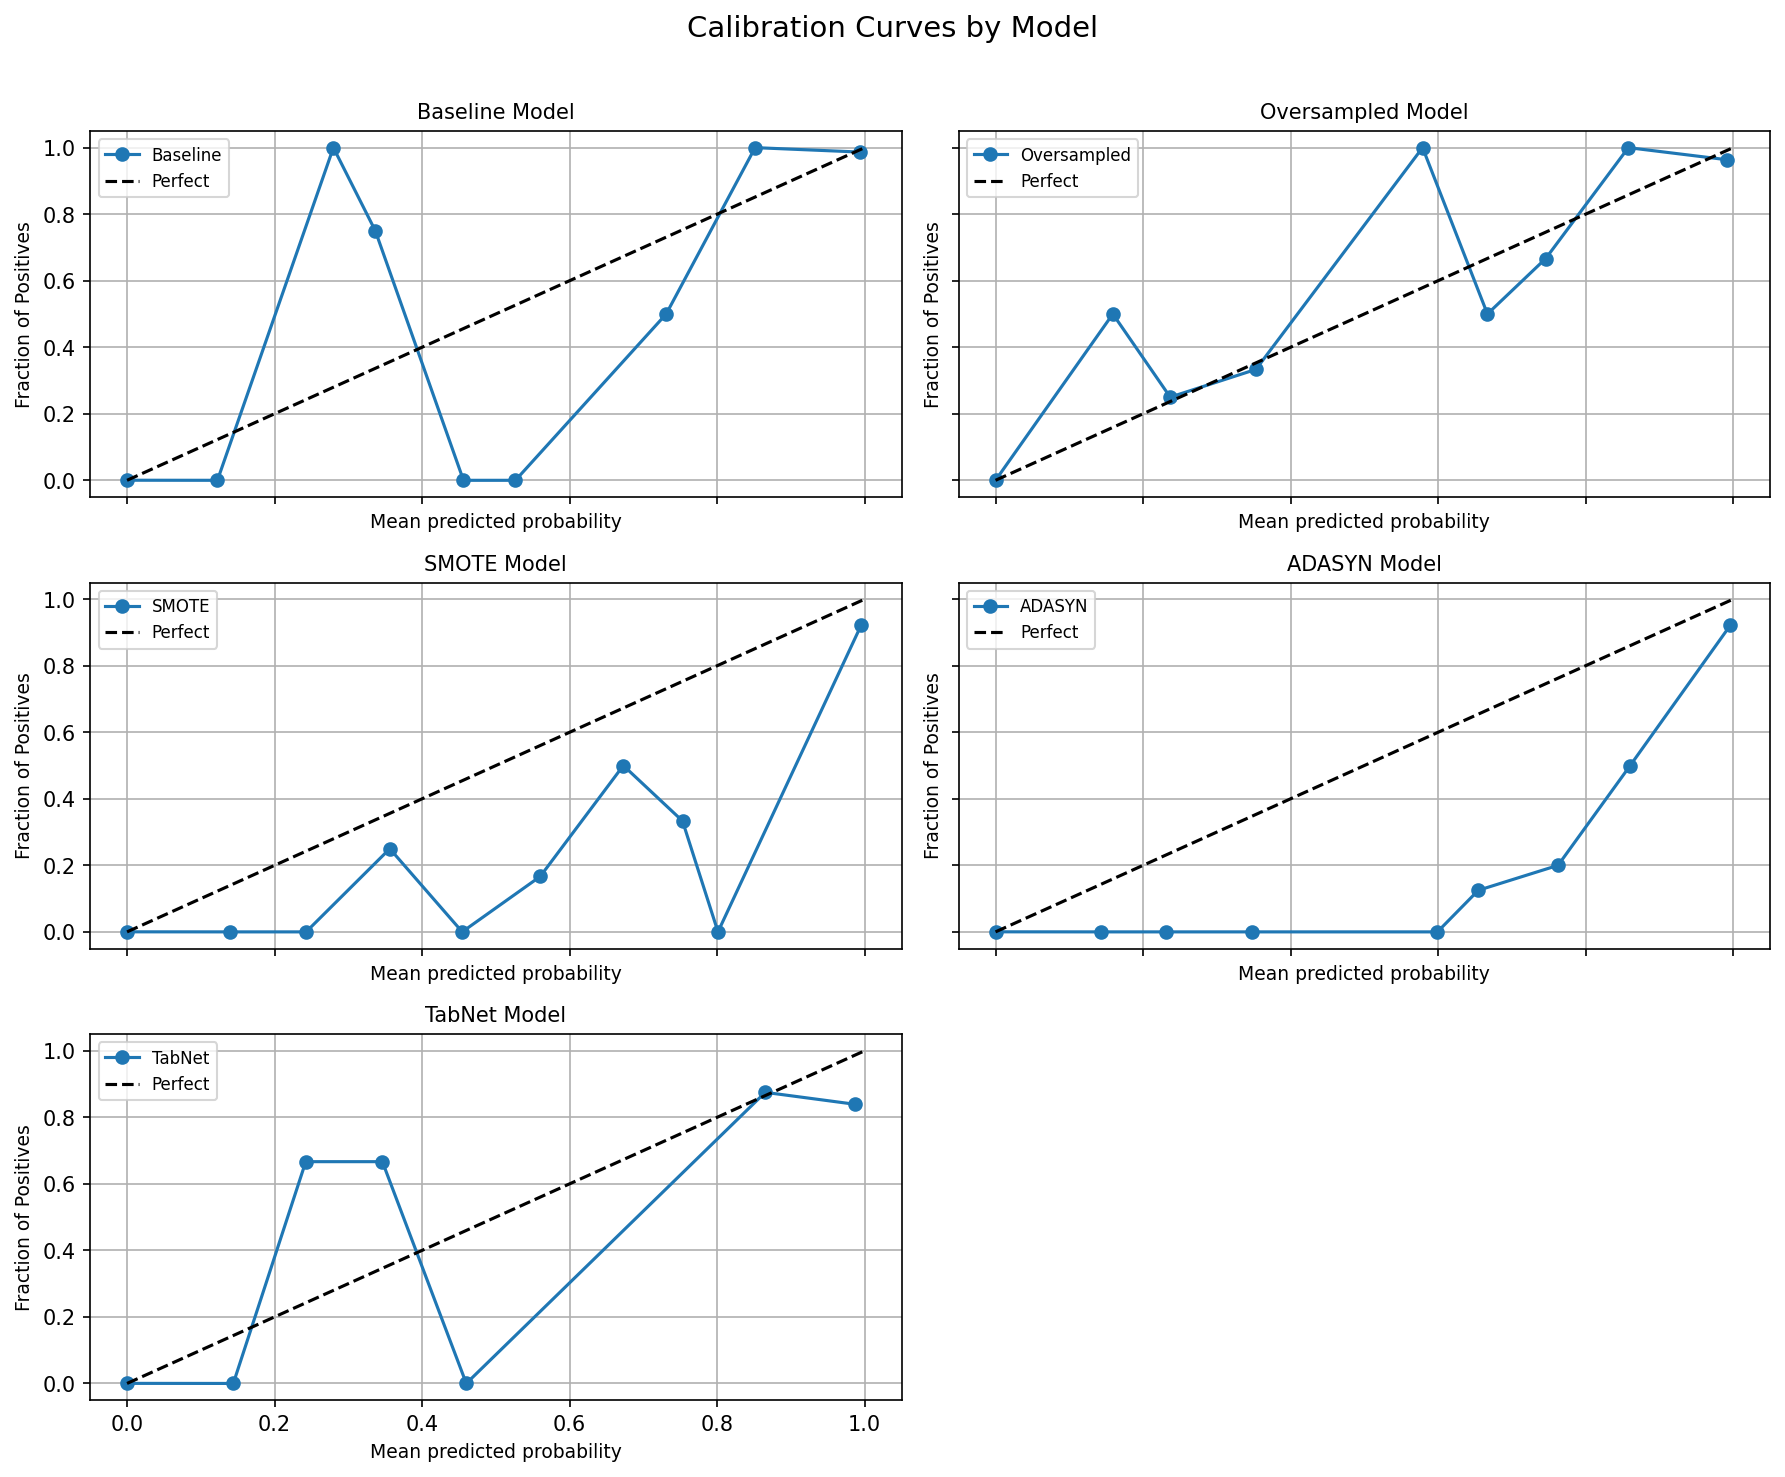

In [ ]:
# TebNet output formatting
probs_tabnet = clf.predict_proba(X_test_np)
if isinstance(probs_tabnet, pd.DataFrame):
    y_prob_tabnet = probs_tabnet.iloc[:, 1]
else:
    y_prob_tabnet = probs_tabnet[:, 1]
    print

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10), dpi=150, sharex=True, sharey=True)
axes = axes.ravel()  # Flatten to 1D array for easy indexing

# Model probability lists
model_preds = [
    ("Baseline", y_prob_preds1),
    ("Oversampled", y_prob_preds2),
    ("SMOTE", model_smote.predict_proba(X_test)[:, 1]),
    ("ADASYN", model_ada.predict_proba(X_test)[:, 1]),
    ("TabNet", y_prob_tabnet)
]

# Plot each
for i, (name, probs) in enumerate(model_preds):
    prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)
    ax = axes[i]
    ax.plot(prob_pred, prob_true, marker='o', label=name)
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect')
    ax.set_xlabel('Mean predicted probability', fontsize=9)
    ax.set_ylabel('Fraction of Positives', fontsize=9)
    ax.set_title(f'{name} Model', fontsize=10)
    ax.grid(True)
    ax.legend(fontsize=8)

# Turn off any unused subplot (if fewer than 6)
if len(model_preds) < len(axes):
    for j in range(len(model_preds), len(axes)):
        fig.delaxes(axes[j])

# Final layout adjustments
fig.suptitle('Calibration Curves by Model', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


### Interpretation of Calibration Curves

Clearly, **Model 2** (trained using the proposed oversampling technique) demonstrates **better-calibrated probability estimates**, closely aligning with the ideal diagonal line. This indicates that the model’s predicted probabilities more accurately reflect the true likelihood of the positive (fraud) class.

In contrast, models trained with **SMOTE** and **ADASYN** appear to be **overconfident**, especially for higher probability bins. Their calibration curves lie significantly below the diagonal, meaning they often **predict higher probabilities for fraud cases than actually warranted**, which could lead to a higher false positive rate.

This supports the conclusion that the **custom oversampling method not only improves classification performance** across multiple metrics, but also yields **more reliable probability estimates**, which is especially critical in high-stakes applications like fraud detection or medical diagnosis.





The resulting AUC close to 0.5 confirms that the model does not memorize or leak test information.

This reassures that the oversampling and training pipeline were properly isolated from the test set, ensuring a fair and unbiased evaluation.

# 13. Conclusion

* Model 2, trained on the custom oversampled dataset, consistently surpassed the baseline, SMOTE, and ADASYN models across all metrics—including Balanced Accuracy, Recall, F1-Score, G-Mean, MCC, ROC-AUC, and PR-AUC—despite except marginally lower precision, which could be further refined through hyperparameter tuning.

* Calibration curves demonstrated that Model 2’s probability estimates are more reliable, while SMOTE and ADASYN tend to be overconfident in minority-class predictions.

* Data leakage tests confirmed the evaluation pipeline’s integrity, with no test set contamination detected.

# 14. Further work
* ### Outlier Handling
I assumed the given sample dataset was a good representation of the population and chose not to remove outliers. Some fraud cases were found to be outliers in earlier research, and I didn’t want to risk losing crucial signals.
<br>

* ### Model Nature
Despite better performance across key metrics in almost everycase which I explored, I feel my approach is still kind-of "scalar", rather than thinking in feature space or leveraging vector representations.

<br>

* ### Model Selection
More effective model selection could be applied during both oversampling and classification stages.

<br>

* ### Data Preprocessing
I didn’t fully leverage preprocessing to enhance pipeline performance—this remains an area for improvement.
<br>

* ### FN and FP Multipliers
The FN and FP multipliers I derived are mathematically justified and align with target intuitions. They are intentionally aggressive to capture the impact of hard frauds and hard legits in the training set, and this intuition carries over effectively to the oversampled dataset. Better multiplies for FNs and FPs can be explored which accounts for outliers as well.
<br>

* ### Optimization of λ₁ and λ₂
In my initial research I  oberserved more synthetic samples don’t equate to better results. There is a sweet spot that can be found
<br>


* ### Variance Mitigation
Variance can be reduced by fine-tuning hyperparameters, but this risks overfitting. A larger validation set is needed to balance generalization and performance.
<br>

* ### Code
It could be arranged and done in a more asthetic way but for this project, I focused more on theory and Maths more than code. 100s of iteration, 50 hours+ computing on google colab GPU, it was build more as an exploration rather than a planned buidling.

<P>

# 15. References

[1] Focal Loss for Dense Object Detection: https://arxiv.org/abs/1708.02002
<br>
[2] Data Distillation: Towards Omni-Supervised Learning :https://arxiv.org/abs/1712.04440
<br>
[3] Data Distillation: A Survey : https://arxiv.org/abs/2301.04272
<br>
[4] AI in Finance: Challenges, Techniques and Opportunities :https://arxiv.org/abs/2107.09051
<br>
[5] AI in Finance: Challenges, Techniques and Opportunities : https://arxiv.org/abs/1603.02754
<br>
[6]Credit Card Transactions Fraud Detection Dataset : https://www.kaggle.com/datasets/kartik2112/fraud-detection
<br>
[7]Credit Card Fraud Detection : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/code
<br>
[8]TabNet: Attentive Interpretable Tabular Learning : https://arxiv.org/abs/1908.07442



In [ ]:
  #------------------#--------------------#---------------------#-----------------------#--------------------#---------------------#-----------------#---------------#